# Indeed data challenge

This is an exercise for the company Indeed.  We are given a file with information about a job including:
* companyId
* jobType
* degree
* major
* industry
* yearsExperience
* milesFromMetropolis

The task is to predict the salary given these features.  I have chosen to use a simple linear regression model to make this prediction.  

# Load data

First I load the data into the notebook.  The first line of the file is a header.

In [1]:
fileName='indeed_data_science_exercise/train_features_2013-03-07.csv'
with open(fileName) as f:
    rawDataX=[line.split(',') for line in f.read().split('\n')[:-1]]

In [2]:
fileName='indeed_data_science_exercise/train_salaries_2013-03-07.csv'
with open(fileName) as f:
    rawDataY=[line.split(',') for line in f.read().split('\n')[:-1]]

In [3]:
rawDataY={line[0]:int(line[1]) for line in rawDataY[1:]}

In [4]:
rawDataX[0]

['jobId',
 'companyId',
 'jobType',
 'degree',
 'major',
 'industry',
 'yearsExperience',
 'milesFromMetropolis']

# map catagorical info to number

Here I map the catagorical data into one hot encodings that I can train the model on.

First we convert the catagory in to an index.

In [5]:
def catToNum(array):
    xToNum={}
    count=0
    for i in array:
        if i not in xToNum:
            xToNum[i]=count
            count+=1
    return xToNum

compToNum=catToNum([line[1] for line in rawDataX[1:]])
jobTypeToNum=catToNum([line[2] for line in rawDataX[1:]])
degreeToNum=catToNum([line[3] for line in rawDataX[1:]])
majorToNum=catToNum([line[4] for line in rawDataX[1:]])
indToNum=catToNum([line[5] for line in rawDataX[1:]])

We create the encoding method using sklearn

In [6]:
from sklearn.preprocessing import OneHotEncoder
def createEncoder(xToNum):
    enc = OneHotEncoder()
    enc.fit([[i] for i in range(len(xToNum))])
    return enc 

encComp=createEncoder(compToNum)
encJobType=createEncoder(jobTypeToNum)
encDegree=createEncoder(degreeToNum)
encMajor=createEncoder(majorToNum)
encInd=createEncoder(indToNum)

Finally, we transform the data

In [7]:
def rawToHot(enc,xToNum,i,rawDataX):
    return encComp.transform(
    [[compToNum[line[1]]] for line in rawDataX[1:]]).toarray().tolist()

In [8]:
hotComp=rawToHot(encComp,compToNum,1,rawDataX)
hotJobType=rawToHot(encJobType,jobTypeToNum,2,rawDataX)
hotDegree=rawToHot(encDegree,degreeToNum,3,rawDataX)
hotMajor=rawToHot(encMajor,majorToNum,4,rawDataX)
hotInd=rawToHot(encInd,indToNum,5,rawDataX)

# Creating feature vectors

in this section I combine the features into a single feature vector.  Later, I will use only select features to explore the importance of the features.

In [9]:
import numpy as np

In [10]:
maxExp=max([float(line[6]) for line in rawDataX[1:]])
maxDist=max([float(line[7]) for line in rawDataX[1:]])

In [11]:
def createFeatures(array):
    xData=[]
    for x in array:
        xData.append(np.concatenate(x).tolist())
    return xData

In [12]:
xData=createFeatures(zip(
    hotComp,
    hotJobType,
    hotDegree,
    hotMajor,
    hotInd,
    [[float(line[6])/maxExp] for line in rawDataX[1:]],
    [[float(line[7])/maxDist] for line in rawDataX[1:]]
    ))

# Model training
In this section, I train the model and test the model using mean square error.  I also make a plot of predicted values vs. actual.

In [12]:
from sklearn.model_selection import train_test_split
from sklearn import linear_model

In [13]:
X_train, X_test, y_train, y_test = train_test_split(
    xData,[rawDataY[line[0]] for line in rawDataX[1:]]
    , test_size=0.25, random_state=0)

In [14]:
regr = linear_model.LinearRegression()

In [13]:
def meanSquareError(y_test,y_pred):
    import math
    tot=0
    for yp,yt in zip(y_pred,y_test):
        tot+=pow(yp-yt,2)
    return math.sqrt(tot/len(y_test))

In [ ]:
# Train the model using the training sets
regr.fit(X_train, y_train)

# Make predictions using the testing set
y_pred = regr.predict(X_test)

The mean square error is somewhat large but not totally unreasonable given that we have used such a simple model.

In [19]:
meanSquareError(y_test,y_pred)

33.98521123054836

We can additionally predict the mean square error if we can simply predicated the answer to be the average of all the salaries.  The error here is not too different from the one given by the linear regression model.

In [25]:
ymean=np.mean(y_train)
meanSquareError(y_test,[ymean for _ in y_pred])

38.68980408004556

Below is a plot of the predicted salary vs the actual salary.  There seems to be a strong trend which is encouraging that we have acually captured something.

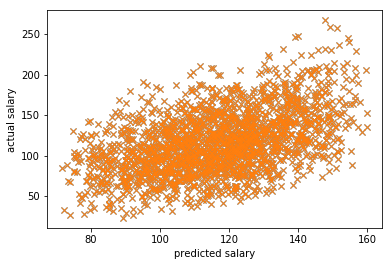

In [23]:
import matplotlib.pyplot as plt

plt.plot(y_pred[:2000],y_test[:2000],'x')
plt.xlabel('predicted salary')
plt.ylabel('actual salary')
plt.show()

# Removing features

In this section I will remove one feature to explore how the error changes.

In [14]:
def modelWrapper(array,rawDataY):
    xData=createFeatures(array)
    X_train, X_test, y_train, y_test = train_test_split(
        xData,[rawDataY[line[0]] for line in rawDataX[1:]]
        , test_size=0.25, random_state=0)
    regr = linear_model.LinearRegression()

    # Train the model using the training sets
    regr.fit(X_train, y_train)

    # Make predictions using the testing set
    y_pred = regr.predict(X_test)

    print meanSquareError(y_test,y_pred)

Removed 'company type'

In [15]:
modelWrapper(zip(
        hotJobType,
        hotDegree,
        hotMajor,
        hotInd,
        [[float(line[6])/maxExp] for line in rawDataX[1:]],
        [[float(line[7])/maxDist] for line in rawDataX[1:]]
        ),rawDataY)

/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/scipy/linalg/basic.py:1226: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  warnings.warn(mesg, RuntimeWarning)


33.9852100261


Remove 'job type'

In [16]:
modelWrapper(zip(
        hotComp,
        hotDegree,
        hotMajor,
        hotInd,
        [[float(line[6])/maxExp] for line in rawDataX[1:]],
        [[float(line[7])/maxDist] for line in rawDataX[1:]]
        ),rawDataY)

33.9852100261


Remove 'degree'

In [ ]:
modelWrapper(zip(
        hotComp,
        hotJobType,
        hotMajor,
        hotInd,
        [[float(line[6])/maxExp] for line in rawDataX[1:]],
        [[float(line[7])/maxDist] for line in rawDataX[1:]]
        ),rawDataY)

33.9852100261


Remove 'major'

In [19]:
modelWrapper(zip(
        hotComp,
        hotJobType,
        hotDegree,
        hotInd,
        [[float(line[6])/maxExp] for line in rawDataX[1:]],
        [[float(line[7])/maxDist] for line in rawDataX[1:]]
        ),rawDataY)

33.9852100261


Remove 'industry'

In [18]:
modelWrapper(zip(
        hotComp,
        hotJobType,
        hotDegree,
        hotMajor,
        [[float(line[6])/maxExp] for line in rawDataX[1:]],
        [[float(line[7])/maxDist] for line in rawDataX[1:]]
        ),rawDataY)

33.9852100261


Remove 'years experience'

In [17]:
modelWrapper(zip(
        hotComp,
        hotJobType,
        hotDegree,
        hotMajor,
        hotInd,
        [[float(line[7])/maxDist] for line in rawDataX[1:]]
        ),rawDataY)

36.9306391037


Remove 'miles from metropolis'

In [ ]:
modelWrapper(zip(
        hotComp,
        hotJobType,
        hotDegree,
        hotMajor,
        hotInd,
        [[float(line[6])/maxExp] for line in rawDataX[1:]]
        ),rawDataY)

To summarize the results above, here are the errors from models were one feature is removed:

|model type        | error           | 
| :------------- |-------------|
| average      | 38.68 |
| all features      | 33.99      |
| company id | 33.99 |
| job type removed | 33.99      |
| degree removed| 33.99 |
| major removed | 33.99 |
| industry removed | 33.99 |
| years experience removed | 36.93 |
| miles from metropolis removed|  |